<a href="https://colab.research.google.com/github/sayid-alt/kulitku-bangkit2024/blob/main/Machine%20Learning/skin_type_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner --upgrade

import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


# Download data from kaggle

In [ ]:
!pip install kaggle


from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayidheykal","key":"e6e9a20922c6182e48e1cbac69a56342"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): Apache 2.0
 99% 123M/124M [00:07<00:00, 23.4MB/s]
100% 124M/124M [00:07<00:00, 17.3MB/s]


In [ ]:
if os.path.isdir('/content/oily-dry-and-normal-skin-types-dataset'):
  shutil.rmtree('/content/oily-dry-and-normal-skin-types-dataset')
!unzip /content/oily-dry-and-normal-skin-types-dataset.zip -d /content/oily-dry-and-normal-skin-types-dataset


Archive:  /content/oily-dry-and-normal-skin-types-dataset.zip
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/README.dataset.txt  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_10583924a54a7cbcf5d0_jpg.rf.7c4cb0ac9522f3a0faaf230527e1abe9.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_1d3b1b41c06745c89fb6_jpg.rf.9fe7b2181a36c2b6f67744be1af2fdd7.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_2e2591d4cf31b8e024a6_jpg.rf.e8a8db4db95cd0a0df0275d75fcd87a0.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_304ff9ea442145481f67_jpg.rf.26e1ca5ca2eb32f5c89509c670ca967a.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_33489ccedfbd77039b4d_jpg.rf.bff22d94ad08b5402f1feb8e304a7368.jpg  
  inflating: /content/oily-dry-

# Utilities

In [ ]:
def move_files(source_dir, destination_dir):
    # Ensure the source and destination directories exist
    if not os.path.exists(source_dir):
        print(f"The source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        print(f"Created the destination directory '{destination_dir}'.")

    # List all files in the source directory
    files = os.listdir(source_dir)

    # Loop through all files and move them to the destination directory
    for file_name in files:
        # Construct full file path
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)

        # Move the file
        shutil.move(source_file, destination_file)

    print(f'{len(os.listdir(destination_dir))} images belong to {destination_dir}')


def create_directory(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully.")
    except Exception as e:
        print(f"Error creating directory '{path}': {e}")



def count_files_and_directories(path):
    file_count = 0
    directory_count = 0

    for dirpath, dirnames, filenames in os.walk(path):
        # Count the number of files in the current directory
        file_count += len(filenames)
        # Count the number of subdirectories in the current directory
        directory_count += len(dirnames)

    return file_count, directory_count


def convert_pb_to_tflite(pb_model_path, tflite_model_path):
    # Load the TensorFlow model
    converter = tf.lite.TFLiteConverter.from_saved_model(pb_model_path)

    # Convert the model to TFLite format
    tflite_model = converter.convert()

    # Save the converted model to a file
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model converted and saved to {tflite_model_path}")


def plot_portion(values, labels, title='Portion of values'):
  fig, ax = plt.subplots()

  sum_values = sum(values)
  percentages = [value / sum_values for value in values]

  bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

  # Create horizontal bar chart
  bars = ax.bar(labels, values, color=bar_colors, label=labels)

  # Add labels to bars with customizations
  ax.bar_label(bars, labels=[f'{round(v * 100, 2)} %' for v in percentages], padding=3, fontsize=10, label_type='center')

  # Set labels
  ax.set_ylabel('values')
  ax.set_title(title)
  ax.legend(title='Fruit color')

  # Show the plot
  plt.show()

def plot_acc_loss(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # save graph to png
  pngfile = 'acc_loss.png'
  if os.path.isfile(pngfile):
    plt.savefig('acc_loss(1).png')
  plt.savefig(f'acc_loss.png')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'accuracy\t: {acc[len(acc)-1]}, val_accuracy\t: {val_acc[len(val_acc)-1]}')

  print(f'loss\t\t: {loss[len(loss)-1]}, val_loss\t: {val_loss[len(val_loss)-1]}')


def move_files_after_split(X, y, base_dir):
  for source_dir, category in zip(X, y):
    filename = source_dir.split('/')[-1]
    destination_dir = os.path.join(base_dir, category, filename)
    shutil.move(source_dir, destination_dir)
    print(f'moved {source_dir} to {destination_dir}')


# Generate data

In [ ]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/'

# training data directory
train_dir = base_dir + 'train'

 # validation data directory
valid_dir = base_dir + 'valid'

# test data directory
test_dir = base_dir + 'test'

train_dir, valid_dir, test_dir

('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train',
 '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid',
 '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test')

## Gathering all picture to one folder as their categories

In [ ]:
# define class names as a label
categories = [name for name in os.listdir(train_dir)]
categories

['normal', 'oily', 'dry']

In [ ]:
# create dicertories for all existing data
all_dir = os.path.join(base_dir, 'all')

for cat in categories:
  create_directory(os.path.join(all_dir, cat))

# move all images to the all directory as a default before splitted
for dirname in [train_dir, valid_dir, test_dir]:
  for cat in categories:
    source_dir = os.path.join(dirname, cat)
    destination_dir = os.path.join(all_dir, cat)
    move_files(source_dir, destination_dir)


Directory '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/normal' created successfully.
Directory '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/oily' created successfully.
Directory '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/dry' created successfully.
1104 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/normal
1000 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/oily
652 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/dry
1215 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/normal
1080 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/oily
723 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/dry
1274 images belong to /content/oily-dry-and-normal-skin-types-dataset/Oi

# EDA

Checking All data in test, train, valid folder (should be empty)

In [ ]:
num_train, num_train_labels = count_files_and_directories(train_dir)
num_valid, num_valid_labels = count_files_and_directories(valid_dir)
num_test, num_test_labels = count_files_and_directories(test_dir)

all, _ = count_files_and_directories(base_dir)

print(f'number of images: {all}\n-------------------\n')
print(f'train data length: {num_train}\nNum of train labels: {num_train_labels}\npercentage: {round(num_train/all*100,2)} %\n')
print(f'valid data length: {num_valid}\nNum of train labels: {num_valid_labels}\npercentage: {round(num_valid/all*100,2)} %\n')
print(f'test data length: {num_test}\nNum of test labels: {num_test_labels}\npercentage: {round(num_test/all*100,2)} %\n')

number of images: 3153
-------------------

train data length: 0
Num of train labels: 3
percentage: 0.0 %

valid data length: 0
Num of train labels: 3
percentage: 0.0 %

test data length: 0
Num of test labels: 3
percentage: 0.0 %



## Look up the quantities of the category directory

normal : 1274
oily : 1120
dry : 758


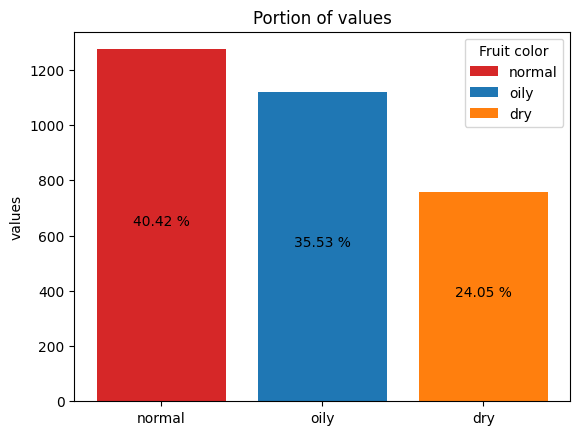

In [ ]:
values = []
for i, class_name in enumerate(categories):
  class_length = len(os.listdir(os.path.join(all_dir, class_name)))
  values.append(class_length)
  print(f'{class_name} : {class_length}')

plot_portion(values, categories)

## Data Distribution

(array([1., 0., 2.]),
 array([ 758.,  930., 1102., 1274.]),
 <BarContainer object of 3 artists>)

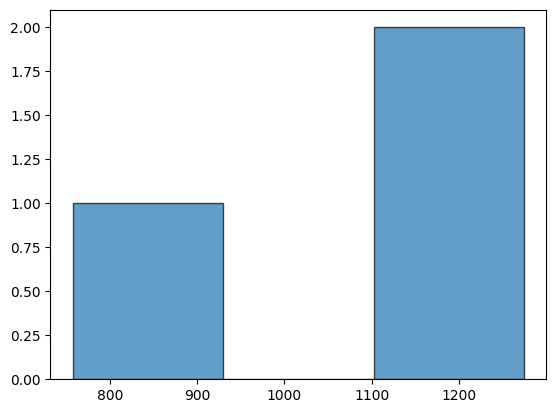

In [ ]:
plt.hist(values, bins=3, alpha=0.7, edgecolor='black')

# Data Preprocessing

In [ ]:
count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

(3152, 3)

In [ ]:
images, category = [], []
for cat in categories:
  path_cat = os.listdir(os.path.join(all_dir, cat))
  for image in path_cat:
    images.append(os.path.join(all_dir, cat, image))
    category.append('dry' if cat == 'dry' else 'normal' if cat == 'normal' else 'oily')


df = pd.DataFrame({'images':images, 'category':category})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.iloc[77]['images'].split('/')[-1]

'oily_6c43ed2461d82f37ec4f_jpg.rf.70d0e2e6758fa4f3c9bda96455700127.jpg'

## Split data

In [ ]:
# Split Train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df['images'], df['category'],
                                                      test_size=0.2, random_state=42,
                                                      stratify=df['category'])

# Split validation set for test set
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2,
                                                    random_state=42, stratify=y_valid)

In [ ]:
# check qty of split
print(f'train: {len(X_train)}\nvalid: {len(X_valid)}\nX_test : {len(X_test)}')

train: 2521
valid: 504
X_test : 127


In [ ]:
# Moving a train files to train directory
move_files_after_split(X_train, y_train, train_dir)
move_files_after_split(X_valid, y_valid, valid_dir)
move_files_after_split(X_test, y_test, test_dir)

moved /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/dry/dry_be047d0e7d2513f90355_jpg.rf.73e87fa0dbb6988c357901e794b87360.jpg to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/dry/dry_be047d0e7d2513f90355_jpg.rf.73e87fa0dbb6988c357901e794b87360.jpg
moved /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/normal/normal_a73be48796366d54b87c_jpg.rf.61754d17a05bd4d7bd5a8e05ab1c7c93.jpg to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_a73be48796366d54b87c_jpg.rf.61754d17a05bd4d7bd5a8e05ab1c7c93.jpg
moved /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/dry/dry_96e0c90bfc8f0751b184_jpg.rf.ddac25d8e2006b459e76f27d58c797a0.jpg to /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/dry/dry_96e0c90bfc8f0751b184_jpg.rf.ddac25d8e2006b459e76f27d58c797a0.jpg
moved /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all/normal/

In [ ]:
# Check if the images from (all) category is moved
count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

(0, 3)

In [ ]:
# Check if the images is moved as a split portion
print(count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test'))
print(count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train'))
print(count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid'))

(127, 3)
(2521, 3)
(504, 3)


In [ ]:
# remove temp file -(all) category-
shutil.rmtree('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

In [ ]:
!zip -r 'skin-type-dataset.zip' '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types'

  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/ (stored 0%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/README.dataset.txt (deflated 24%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/ (stored 0%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/ (stored 0%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_36a4bfd6cec42fa48752_jpg.rf.5c9bd08819406d5fd70b77d3f6b4732f.jpg (deflated 3%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_a1ec8b6d86e28a74c32c_jpg.rf.bf082b5f502fac3457480e8dd6cfb6c1.jpg (deflated 9%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_b633811016e2562ad204_jpg.rf.5d573b281e74147a6f16ce268b668127.jpg (deflated 8%)
  adding: content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-T

# Generate Data (after split 80/15/5)

In [ ]:
if os.path.isdir('/content/skin-type-dataset.zip'):
  shutil.rmtree('/content/skin-type-dataset')
!unzip /content/skin-type-dataset.zip -d /content/skin-type-dataset

Archive:  /content/skin-type-dataset.zip
   creating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/
  inflating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/README.dataset.txt  
   creating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/
   creating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/
  inflating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_36a4bfd6cec42fa48752_jpg.rf.5c9bd08819406d5fd70b77d3f6b4732f.jpg  
  inflating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train/normal/normal_a1ec8b6d86e28a74c32c_jpg.rf.bf082b5f502fac3457480e8dd6cfb6c1.jpg  
  inflating: /content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin

In [ ]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types'

# remove readme file
readme_file = os.path.join(base_dir, 'README.dataset.txt')
if os.path.isfile(readme_file):
  os.remove(readme_file)

# training data directory
train_dir = os.path.join(base_dir, 'train')

 # validation data directory
valid_dir =os.path.join(base_dir, 'valid')

# test data directory
test_dir = os.path.join(base_dir, 'test')

train_dir, valid_dir, test_dir

('/content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train',
 '/content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid',
 '/content/skin-type-dataset/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test')

## Data generator

In [ ]:
# create imageDataGenerator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# create Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

Found 2521 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

# Data Visualitaion

In [ ]:
split_names = ['train','valid', 'test']
num_train, _ = count_files_and_directories(train_dir)
num_valid, _ = count_files_and_directories(valid_dir)
num_test, _ = count_files_and_directories(test_dir)
values = [num_train, num_valid, num_test]

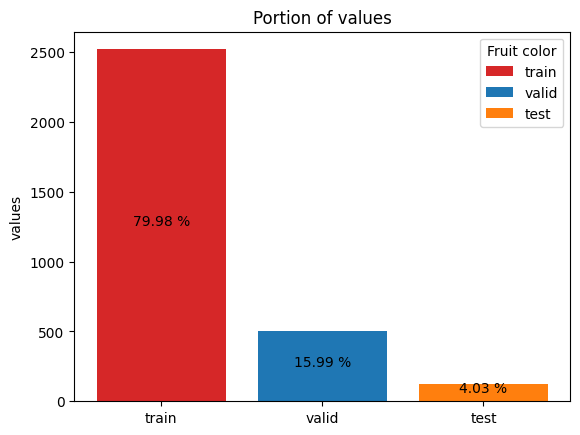

In [ ]:
plot_portion(values, split_names)

# Build model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
def build_model(hp):
  x = base_model.output

  if hp.Boolean("flatten"):
      x = Flatten()(x)
  elif hp.Boolean("global_average_pooling"):
      x = GlobalAveragePooling2D()(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=1024, step=32),
        activation='relu')(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=1024, step=32),
        activation='relu')(x)

  if hp.Boolean("batch_normalization"):
    x = BatchNormalization()(x)

  predictions = Dense(3, activation='softmax')(x)

  # Create model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Define the optimizer learning rate as a hyperparameter.
  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")

  # Define learning rate scheduler
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# create a model
model = build_model(keras_tuner.HyperParameters())
model

In [ ]:
# define tuner using RandomSearch
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/keras_tuner/",
    project_name="skin_type_model",
)

# print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
flatten (Boolean)
{'default': False, 'conditions': []}
global_average_pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# start search best parameters
tuner.search(train_generator, epochs=2, validation_data=validation_generator)

Trial 5 Complete [00h 05m 49s]
val_accuracy: 0.2400793582201004

Best val_accuracy So Far: 0.4047619104385376
Total elapsed time: 00h 15m 47s


## Query Result

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=3)
best_model = models[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
best_model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tuner.results_summary()

Results summary
Results in /content/keras_tuner/skin_type_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
flatten: True
global_average_pooling: True
dropout: True
units: 640
batch_normalization: True
learning_rate: 0.00044349967481903434
Score: 0.4047619104385376

Trial 2 summary
Hyperparameters:
flatten: False
global_average_pooling: True
dropout: True
units: 160
batch_normalization: True
learning_rate: 0.0003804463610863373
Score: 0.4047619104385376

Trial 4 summary
Hyperparameters:
flatten: False
global_average_pooling: True
dropout: True
units: 96
batch_normalization: True
learning_rate: 1.0742603453225329e-06
Score: 0.2400793582201004

Trial 0 summary
Hyperparameters:
flatten: False
global_average_pooling: False
dropout: False
units: 64
batch_normalization: True
learning_rate: 0.007293577753293809
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", l

In [ ]:
!zip -r /content/skin_type_model.zip /content/keras_tuner/skin_type_model

  adding: content/keras_tuner/skin_type_model/ (stored 0%)
  adding: content/keras_tuner/skin_type_model/oracle.json (deflated 65%)
  adding: content/keras_tuner/skin_type_model/trial_1/ (stored 0%)
  adding: content/keras_tuner/skin_type_model/trial_1/checkpoint.index (deflated 80%)
  adding: content/keras_tuner/skin_type_model/trial_1/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: content/keras_tuner/skin_type_model/trial_1/checkpoint (deflated 48%)
  adding: content/keras_tuner/skin_type_model/trial_1/trial.json (deflated 67%)
  adding: content/keras_tuner/skin_type_model/trial_2/ (stored 0%)
  adding: content/keras_tuner/skin_type_model/trial_2/checkpoint.index (deflated 79%)
  adding: content/keras_tuner/skin_type_model/trial_2/checkpoint.data-00000-of-00001 (deflated 27%)
  adding: content/keras_tuner/skin_type_model/trial_2/checkpoint (deflated 48%)
  adding: content/keras_tuner/skin_type_model/trial_2/trial.json (deflated 67%)
  adding: content/keras_tuner/skin_type_mod

In [ ]:
files.download('/content/skin_type_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set Callbacks

In [ ]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v02',
    verbose=1,
    monitor='val_accuracy',
    save_best_only=True
)

csv_logger = tf.keras.callbacks.CSVLogger(f'/content/csv_logger.csv')

## Retrain Models

In [ ]:
def train_model(epochs, steps_per_epoch, tuner, unfreeze=None, callbacks=None):
  # Get the top 2 hyperparameters.
  best_hps = tuner.get_best_hyperparameters(5)

  # Build the model with the best hp.
  model = build_model(best_hps[0])

  # # freeze some layers and
  # for layer in base_model.layers:
  #   layer.trainable = False

  # if unfreeze is not None:
  #   # unfreeze some layers
  #   for layer in base_model.layers[-unfreeze:]:
  #     layer.trainable = True

  history = model.fit(train_generator, epochs=epochs,
            batch_size=32,
            verbose=2,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[callbacks])

  return history

In [ ]:
EPOCHS = 50
steps_per_epoch = train_generator.samples // train_generator.batch_size
callbacks = [ckpt_callback, csv_logger]

In [ ]:

history = train_model(epochs=EPOCHS,
                      steps_per_epoch=steps_per_epoch, tuner=tuner,
                      callbacks=callbacks)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.39583, saving model to /content/ckpt/model_01_0.37_0.40_v02
78/78 - 146s - loss: 1.3609 - accuracy: 0.3668 - val_loss: 1.3566 - val_accuracy: 0.3958 - 146s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.39583 to 0.40833, saving model to /content/ckpt/model_02_0.38_0.41_v02
78/78 - 110s - loss: 1.2840 - accuracy: 0.3753 - val_loss: 1.0844 - val_accuracy: 0.4083 - 110s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.40833
78/78 - 49s - loss: 1.2163 - accuracy: 0.3921 - val_loss: 88.1967 - val_accuracy: 0.3750 - 49s/epoch - 631ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.40833
78/78 - 48s - loss: 1.1962 - accuracy: 0.3805 - val_loss: 215.5572 - val_accuracy: 0.2833 - 48s/epoch - 615ms/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.40833
78/78 - 49s - loss: 1.1970 - accuracy: 0.3732 - val_loss: 1.7747 - val_accuracy: 0.3979 - 49s/epoch - 629ms/step
Epoch 

In [ ]:
history_ft1 = train_model(epochs=EPOCHS,
                      steps_per_epoch=steps_per_epoch, unfreeze=30
                      callbacks=callbacks)

# Evaluation

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

NameError: name 'model' is not defined

In [ ]:
# Plot training & validation accuracy values
plot_acc_loss(history)

In [ ]:

# fine-tuned plot model
plot_acc_loss(history_ft)

In [ ]:
model.save('model_retrain_01.h5')

# Download checkpoint file

In [ ]:

!zip -r model.zip /content/ckpt

In [ ]:
# tmp code for download csv log
files.download(f'/content/log/csv_logger.csv')


In [ ]:
!unzip /content/model.zip -d /content/model

In [ ]:
files.save(model)

AttributeError: module 'google.colab.files' has no attribute 'save'

In [ ]:
files.download('model.zip')

# convert saved model pb to tfjs

In [ ]:
!unzip "/content/skin_type_model.zip" -d "/content/model-pb"

Archive:  /content/skin_type_model.zip
   creating: /content/model-pb/model-03-055-053/
  inflating: /content/model-pb/__MACOSX/._model-03-055-053  
  inflating: /content/model-pb/model-03-055-053/.DS_Store  
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._.DS_Store  
  inflating: /content/model-pb/model-03-055-053/fingerprint.pb  
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._fingerprint.pb  
  inflating: /content/model-pb/model-03-055-053/keras_metadata.pb  
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._keras_metadata.pb  
   creating: /content/model-pb/model-03-055-053/variables/
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._variables  
  inflating: /content/model-pb/model-03-055-053/saved_model.pb  
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._saved_model.pb  
   creating: /content/model-pb/model-03-055-053/assets/
  inflating: /content/model-pb/__MACOSX/model-03-055-053/._assets  
  inflating: /content/model-pb/model-

In [ ]:
pb_model_path = '/content/model-pb/model-03-055-053'
tflite_model_path = '/content/model.tflite'
convert_pb_to_tflite(pb_model_path, tflite_model_path)

Model converted and saved to /content/model.tflite


# Predict new image

In [ ]:
class_name = ['dry', 'normal', 'oily']

In [ ]:
# Upload the image to Colab
from google.colab import files
uploaded = files.upload()

# Load the model

# Path to the directory containing the SavedModel
saved_model_path = '/content/model-pb/model-03-055-053'

# Load the SavedModel
model = tf.saved_model.load(saved_model_path)

# Access the default serving function
infer = model.signatures['serving_default']
print(infer.structured_outputs)

# Preprocess the uploaded image

# Assuming the uploaded file is in the current directory
image_path = list(uploaded.keys())[0]

# Load and preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img

img_array, original_img = preprocess_image(image_path)


# Convert the numpy array to a tensor
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

# Make predictions
predictions = infer(img_tensor)

# Assuming the model outputs a dictionary with keys corresponding to the outputs
output_key = 'dense_1' # Change this to the actual key used by your model
predicted_classes = predictions[output_key].numpy()

print(predicted_classes)

# Step 5: Post-process and interpret results
# Assuming it's a classification model and the result is a probability distribution over classes
plt.imshow(original_img)
plt.show()
predicted_class = np.argmax(predicted_classes, axis=-1)
print(f'Predicted class: {predicted_class[0]}')
print(f'type: {class_name[predicted_class[0]]}')


KeyboardInterrupt: 